# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [3]:
import numpy as np
import torch
from task2_preprocessing import Batcher
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook
from sklearn.metrics.pairwise import cosine_distances
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
device = torch.device('cuda')
# device = torch.device('cpu')
torch.cuda.is_available()

True

In [0]:
class SkipGram:
    def __init__(self, window_size=2, batch_size=10, vocab_size=10000,
                 embed_dim=100, learning_rate = 1e-4):
        self.window_size = window_size
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.learning_rate = learning_rate
        self.unknown = '<UNK>'

        self.model = torch.nn.Sequential(
            torch.nn.Embedding(vocab_size, embed_dim),
            torch.nn.Linear(embed_dim, vocab_size, bias=False))
        self.model = self.model.to(device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
  
    def fit(self, batcher, num_iter=1):
        self.word2Ind = batcher.word2Ind
        self.ind2Word = batcher.ind2Word
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.loss_history = []
        start = time.time()

        for k in tqdm_notebook(range(num_iter)):
            num_batch = 0
            print(f'---Epoch: {k}---')
            for batch in tqdm_notebook(batcher):
                predicted = self.model(torch.from_numpy(batch[0]).to(device, dtype=torch.long))
                predicted = predicted.expand(2 * self.window_size, -1, -1).permute(1, 2, 0)
                loss = self.loss_fn(predicted, torch.from_numpy(batch[1]).to(device, dtype=torch.long))
                num_batch += 1
                
                if num_batch % 100 == 0:
                    now = time.time()
                    print(f'Batch number: {num_batch}\t loss: {loss} \t time elapsed: {round(now - start)}')

                if num_batch % 10 == 0:
                    self.loss_history.append(loss)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            batcher.reset()
            
            
        
    def build_word2vec(self):
        u, v = list(self.model.parameters())
        vecs = (u + v) / 2
        self.w2v_dict = {self.ind2Word[ind] : vecs[ind].detach().cpu().numpy() for ind in self.ind2Word.keys()}
        self.v2w_dict = {tuple(v): k for k, v in self.w2v_dict.items()}

    def word2vec(self, words):
        return [self.w2v_dict[word] if word in self.w2v_dict 
                else self.w2v_dict[self.unknown] for word in words]
    
    def vec2word(self, vectors):
        return [self.v2w_dict[tuple(vector)] if tuple(vector) in self.v2w_dict
                else self.unknown for vector in vectors]
        
    def top_10_cosine_closest(self, vector):
        all_vectors = np.array(list(self.w2v_dict.values()))
        distances = cosine_distances(vector.reshape(1, -1), all_vectors)
        sort_ind = np.argsort(distances.flatten())
        return all_vectors[sort_ind][:10]
        
    # positive1 + positive2 - negative = ...
    def analogy(self, positive1, negative, positive2):
        pos1_vec, pos2_vec, neg_vec = self.word2vec((positive1, positive2, negative))
        result_vec = pos1_vec - neg_vec + pos2_vec
        closest_vec = self.top_10_cosine_closest(result_vec)
        # исключаем сами положительные слова
        closest_vec = [v for v in closest_vec if (np.any(v != pos1_vec) and np.any(v != pos2_vec))]

        return self.v2w_dict[tuple(closest_vec[0])]

In [0]:
# del model
torch.cuda.empty_cache()

In [0]:
batch_size = 8192
window_size = 4
vocab_size = 15000
data_percent = 1
data_path = '/content/drive/My Drive/Colab Notebooks/text8'
batcher = Batcher(batch_size=batch_size, window_size=window_size,
                  data_percent=data_percent, vocab_size = vocab_size,
                  data_path=data_path)
# batcher.reset()

In [0]:
learning_rate = 1e-3
embed_dim = 300
model = SkipGram(window_size=window_size, batch_size=batch_size,
                 embed_dim=embed_dim, vocab_size=vocab_size,
                 learning_rate=learning_rate)

In [0]:
model.fit(batcher, num_iter=5)

---Epoch: 0---


Batch number: 100	 loss: 7.7570481300354 	 time elapsed: 34
Batch number: 200	 loss: 6.988358497619629 	 time elapsed: 69
Batch number: 300	 loss: 6.7220458984375 	 time elapsed: 103
Batch number: 400	 loss: 6.642545223236084 	 time elapsed: 137
Batch number: 500	 loss: 6.56727933883667 	 time elapsed: 172
Batch number: 600	 loss: 6.528836727142334 	 time elapsed: 206
Batch number: 700	 loss: 6.511852741241455 	 time elapsed: 240
Batch number: 800	 loss: 6.49927282333374 	 time elapsed: 275
Batch number: 900	 loss: 6.503966808319092 	 time elapsed: 309
Batch number: 1000	 loss: 6.484618663787842 	 time elapsed: 344
Batch number: 1100	 loss: 6.510096549987793 	 time elapsed: 378
Batch number: 1200	 loss: 6.483474254608154 	 time elapsed: 413
Batch number: 1300	 loss: 6.4832539558410645 	 time elapsed: 447
Batch number: 1400	 loss: 6.471009254455566 	 time elapsed: 482
Batch number: 1500	 loss: 6.460145473480225 	 time elapsed: 516
Batch number: 1600	 loss: 6.453639030456543 	 time elaps

Batch number: 100	 loss: 6.4299750328063965 	 time elapsed: 749
Batch number: 200	 loss: 6.4347004890441895 	 time elapsed: 784
Batch number: 300	 loss: 6.434138774871826 	 time elapsed: 818
Batch number: 400	 loss: 6.455082893371582 	 time elapsed: 853
Batch number: 500	 loss: 6.441824436187744 	 time elapsed: 887
Batch number: 600	 loss: 6.397521018981934 	 time elapsed: 922
Batch number: 700	 loss: 6.3934712409973145 	 time elapsed: 956
Batch number: 800	 loss: 6.424622535705566 	 time elapsed: 991
Batch number: 900	 loss: 6.432526588439941 	 time elapsed: 1025
Batch number: 1000	 loss: 6.430072784423828 	 time elapsed: 1059
Batch number: 1100	 loss: 6.411985397338867 	 time elapsed: 1094
Batch number: 1200	 loss: 6.426111221313477 	 time elapsed: 1128
Batch number: 1300	 loss: 6.401973724365234 	 time elapsed: 1163
Batch number: 1400	 loss: 6.408928871154785 	 time elapsed: 1197
Batch number: 1500	 loss: 6.430144786834717 	 time elapsed: 1232
Batch number: 1600	 loss: 6.40643548965

Batch number: 100	 loss: 6.399522304534912 	 time elapsed: 1465
Batch number: 200	 loss: 6.408908367156982 	 time elapsed: 1499
Batch number: 300	 loss: 6.4119768142700195 	 time elapsed: 1534
Batch number: 400	 loss: 6.419021129608154 	 time elapsed: 1568
Batch number: 500	 loss: 6.402402400970459 	 time elapsed: 1603
Batch number: 600	 loss: 6.392198085784912 	 time elapsed: 1637
Batch number: 700	 loss: 6.38673210144043 	 time elapsed: 1671
Batch number: 800	 loss: 6.394443035125732 	 time elapsed: 1706
Batch number: 900	 loss: 6.416348457336426 	 time elapsed: 1740
Batch number: 1000	 loss: 6.387762069702148 	 time elapsed: 1775
Batch number: 1100	 loss: 6.384437084197998 	 time elapsed: 1809
Batch number: 1200	 loss: 6.390633583068848 	 time elapsed: 1844
Batch number: 1300	 loss: 6.37438440322876 	 time elapsed: 1878
Batch number: 1400	 loss: 6.38192892074585 	 time elapsed: 1913
Batch number: 1500	 loss: 6.364502906799316 	 time elapsed: 1947
Batch number: 1600	 loss: 6.37387228

Batch number: 100	 loss: 6.342355728149414 	 time elapsed: 2181
Batch number: 200	 loss: 6.368214130401611 	 time elapsed: 2215
Batch number: 300	 loss: 6.36722993850708 	 time elapsed: 2249
Batch number: 400	 loss: 6.376766681671143 	 time elapsed: 2284
Batch number: 500	 loss: 6.371712684631348 	 time elapsed: 2318
Batch number: 600	 loss: 6.39306640625 	 time elapsed: 2353
Batch number: 700	 loss: 6.379345893859863 	 time elapsed: 2387
Batch number: 800	 loss: 6.394504547119141 	 time elapsed: 2421
Batch number: 900	 loss: 6.3764729499816895 	 time elapsed: 2456
Batch number: 1000	 loss: 6.380313873291016 	 time elapsed: 2490
Batch number: 1100	 loss: 6.368480205535889 	 time elapsed: 2525
Batch number: 1200	 loss: 6.354128360748291 	 time elapsed: 2559
Batch number: 1300	 loss: 6.389604568481445 	 time elapsed: 2594
Batch number: 1400	 loss: 6.371077060699463 	 time elapsed: 2628
Batch number: 1500	 loss: 6.365727424621582 	 time elapsed: 2663
Batch number: 1600	 loss: 6.3615293502

Batch number: 100	 loss: 6.345316410064697 	 time elapsed: 2897
Batch number: 200	 loss: 6.367745399475098 	 time elapsed: 2931
Batch number: 300	 loss: 6.340740203857422 	 time elapsed: 2966
Batch number: 400	 loss: 6.353536128997803 	 time elapsed: 3000
Batch number: 500	 loss: 6.348288536071777 	 time elapsed: 3034
Batch number: 600	 loss: 6.3741774559021 	 time elapsed: 3069
Batch number: 700	 loss: 6.354700565338135 	 time elapsed: 3103
Batch number: 800	 loss: 6.341732025146484 	 time elapsed: 3138
Batch number: 900	 loss: 6.366746425628662 	 time elapsed: 3172
Batch number: 1000	 loss: 6.37184476852417 	 time elapsed: 3207
Batch number: 1100	 loss: 6.368610382080078 	 time elapsed: 3241
Batch number: 1200	 loss: 6.3440399169921875 	 time elapsed: 3276
Batch number: 1300	 loss: 6.3591628074646 	 time elapsed: 3310
Batch number: 1400	 loss: 6.371921539306641 	 time elapsed: 3344
Batch number: 1500	 loss: 6.337765693664551 	 time elapsed: 3379
Batch number: 1600	 loss: 6.3553147315

In [0]:
# torch.save(model, '/content/drive/My Drive/Colab Notebooks/word2vecBIG.pt')
# model = torch.load('/content/drive/My Drive/Colab Notebooks/word2vecBIG.pt')

Для каждого тест кейса указано количество правильных ответов и количество тестов.

In [0]:
intr_test_file = open('word_similarity_test.txt.txt')
intr_text = intr_test_file.read().lower()
intr_test_cases = intr_text.split(':')[1:]
intr_results = {}
for test_case in tqdm_notebook(intr_test_cases):
    lines = test_case.split('\n')
    name = lines[0]
    true_analogies = [line.split()[3] for line in lines[1:-1]]
    answers = []
    for line in tqdm_notebook(lines[1:-1]):
        answer = model.analogy(*line.split()[:3])
        answers.append(answer)
        
        
    total_analogies = len(true_analogies)
    
    correct_guesses = np.sum([pair[0] == pair[1] for pair in zip(answers, true_analogies)])
    print(name, correct_guesses, total_analogies)


 capital-common-countries 2 506


 capital-world 4 4524


 currency 0 866


 city-in-state 0 2467


 family 5 506


 gram1-adjective-to-adverb 4 992


 gram2-opposite 4 812


 gram3-comparative 1 1332


 gram4-superlative 1 1122


 gram5-present-participle 0 1056


 gram6-nationality-adjective 2 1599


 gram7-past-tense 13 1560


 gram8-plural 14 1332


 gram9-plural-verbs 7 869



Модель обучалась примерно 1 час на Colab с GPU ускорителем.

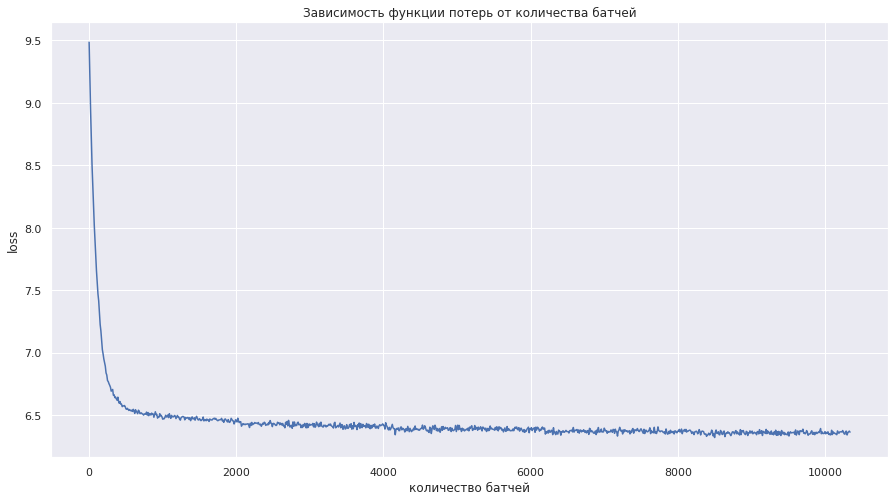

In [10]:
sns.set(style='darkgrid')
plt.figure(figsize = (15, 8))
plt.plot(10 * np.arange(len(model.loss_history)), model.loss_history)
# plt.ylim((0, 5))
plt.xlabel('количество батчей')
plt.ylabel('loss')
plt.title('Зависимость функции потерь от количества батчей')
plt.show()

In [0]:
test_words = ['football', 'basketball', 'baseball',
              'physics', 'math', 'chemistry', 'biology', 'philosophy',
              'head', 'body', 'hand', 'arm', 'leg', 'foot',
              'he', 'she', 'it', 'i', 'you', 'they',
             ]

# test_words = set([batcher.ind2Word[token] for token in batcher.tokens[:100]])

model.build_word2vec()
word_vectors = model.word2vec(test_words)

In [0]:
# umap показался лучше, чем предложенные в задании библиотеки
import umap
reducer = umap.UMAP()
word_vectors_embedded = reducer.fit_transform(word_vectors)

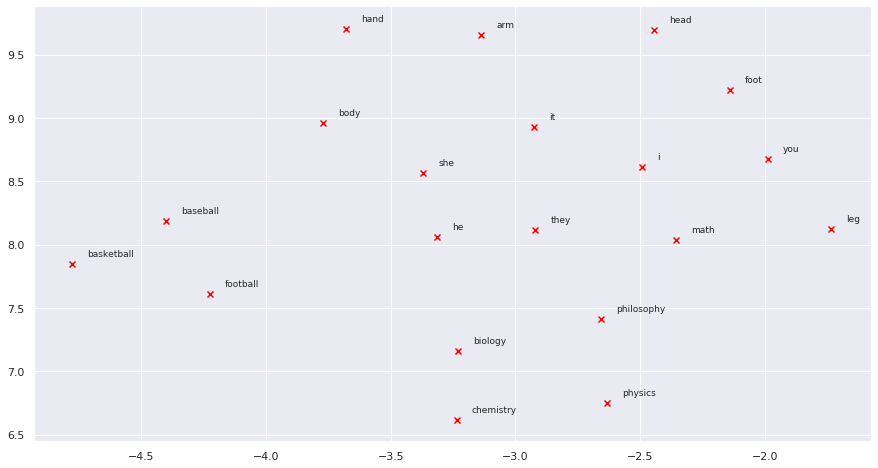

In [22]:
plt.figure(figsize=(15, 8))

x_coords = word_vectors_embedded[:, 0]
y_coords = word_vectors_embedded[:, 1]
 
x_text_shift = (np.max(x_coords) - np.min(x_coords)) / 50
y_text_shift = (np.max(y_coords) - np.min(y_coords)) / 50

for i, word in enumerate(test_words):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+x_text_shift, y+y_text_shift, word, fontsize=9)

plt.show()

Видно, что похожие по смыслу слова кластеризуются.